## Importing the libraries

In [184]:
import numpy as np
import pandas as pd
import librosa
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## 顯示音頻訊號圖

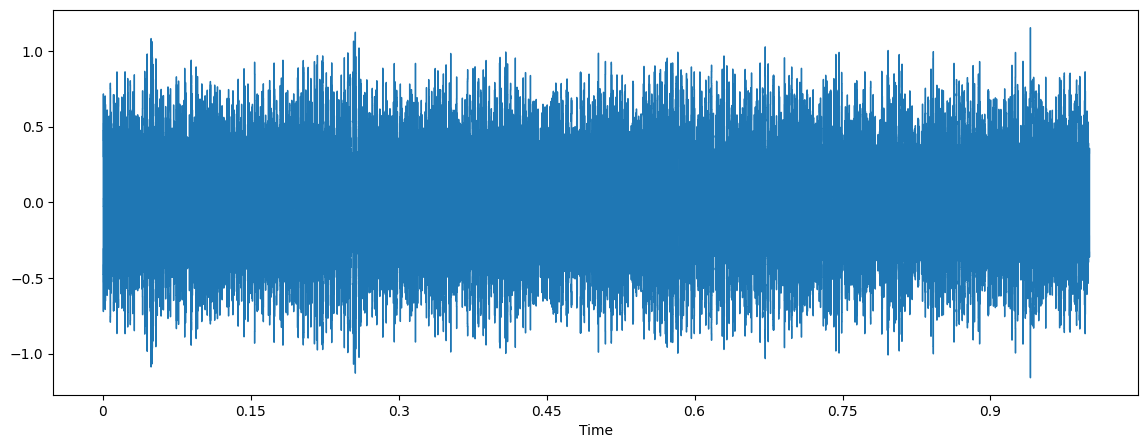

In [196]:
path = '/kaggle/input/recoding-data/UAV Recordings 1s/UAV Recordings 1s/Healthy/recording_2023-03-02_14-07-33_012.wav'

# 讀取音頻文件

plt.figure(figsize=(14,5))
data, sampling_rate = librosa.load(path)
librosa.display.waveshow(data,sr=sampling_rate)

## 顯示MFCCs特徵圖

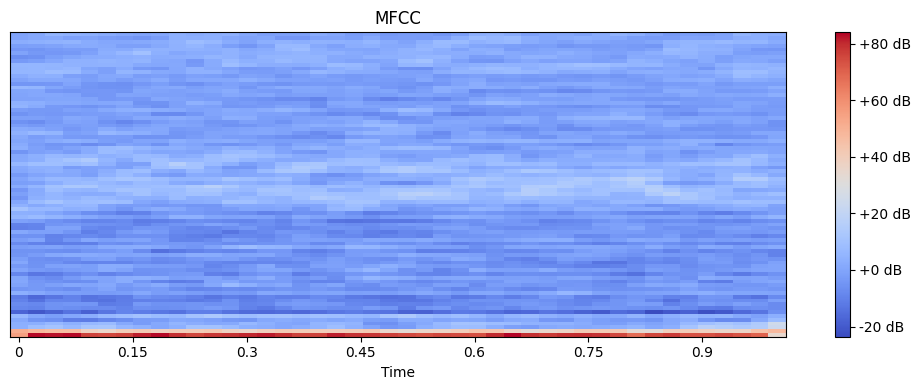

In [198]:
# 提取MFCCs特徵
mfccs_features = librosa.feature.mfcc(y = data, sr = sampling_rate, n_mfcc = 80)

# 繪製MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs_features, x_axis='time', sr=sampling_rate)
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC')
plt.tight_layout()
plt.show()

## 加載音頻訊號

In [185]:
data_path = '/kaggle/input/recoding-data/UAV Recordings 1s/UAV Recordings 1s'

## 音頻訊號進行MFCCs特徵提取

In [186]:
def load_data(data_dir):
    datasets = []
    labels = []
    categories = os.listdir(data_dir)
    for index, folder in enumerate(categories):
        for filename in os.listdir(data_dir+"/"+folder):
            data, sampling_rate = librosa.load(data_dir+"/"+folder+"/"+filename)
            mfccs_features = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=80)
            mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
            datasets.append(np.array(mfccs_scaled_features))
            labels.append(categories[index])
    return np.array(datasets), np.array(labels)

datasets, labels = load_data(data_path)

In [187]:
datasets = datasets.astype('float32')

labelencoder = LabelEncoder()

labelsOneHot = to_categorical(labelencoder.fit_transform(labels))

## 切分成訓練資料、測試資料，8:2的比例

In [188]:
X_train, X_test, y_train, y_test = train_test_split(datasets, labelsOneHot, test_size = 0.2, stratify = labelsOneHot, random_state = 3)

print("----------Train-------------")
print(X_train.shape)

print("----------Test--------------")
print(X_test.shape)

----------Train-------------
(4512, 80)
----------Test--------------
(1128, 80)


## 類別數量

In [189]:
num_classes = len(np.unique(labels))

## 建立NN模型

In [190]:
model=Sequential()

#Input layer
model.add(Flatten(input_shape=(80,)))

#hidden layer 1
model.add(Dense(512, Activation('relu')))

#hidden layer 2
model.add(Dense(128, Activation('relu')))

#hidden layer 3
model.add(Dense(64, Activation('relu')))

# 使用Dropout防止過度擬合
model.add(Dropout(0.25))

#Output layer
model.add(Dense(num_classes, Activation('softmax')))

In [191]:
# 選擇損失函數、優化方法及成效衡量方式
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 80)                0         
                                                                 
 dense_63 (Dense)            (None, 512)               41472     
                                                                 
 dense_64 (Dense)            (None, 128)               65664     
                                                                 
 dense_65 (Dense)            (None, 64)                8256      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_66 (Dense)            (None, 5)                 325       
                                                                 
Total params: 115717 (452.02 KB)
Trainable params: 11

## 模型訓練

In [192]:
train_history = model.fit(X_train, y_train, validation_split=0.2, batch_size = 100, epochs = 100, verbose=2)

Epoch 1/100
37/37 - 1s - loss: 1.8088 - accuracy: 0.4442 - val_loss: 0.9010 - val_accuracy: 0.6423 - 1s/epoch - 37ms/step
Epoch 2/100
37/37 - 0s - loss: 0.8541 - accuracy: 0.6686 - val_loss: 0.7329 - val_accuracy: 0.6844 - 248ms/epoch - 7ms/step
Epoch 3/100
37/37 - 0s - loss: 0.7122 - accuracy: 0.7207 - val_loss: 0.5997 - val_accuracy: 0.7763 - 250ms/epoch - 7ms/step
Epoch 4/100
37/37 - 0s - loss: 0.6156 - accuracy: 0.7709 - val_loss: 0.5514 - val_accuracy: 0.7874 - 255ms/epoch - 7ms/step
Epoch 5/100
37/37 - 0s - loss: 0.5433 - accuracy: 0.7902 - val_loss: 0.5023 - val_accuracy: 0.8018 - 208ms/epoch - 6ms/step
Epoch 6/100
37/37 - 0s - loss: 0.4756 - accuracy: 0.8216 - val_loss: 0.4142 - val_accuracy: 0.8405 - 208ms/epoch - 6ms/step
Epoch 7/100
37/37 - 0s - loss: 0.4416 - accuracy: 0.8332 - val_loss: 0.3727 - val_accuracy: 0.8583 - 228ms/epoch - 6ms/step
Epoch 8/100
37/37 - 0s - loss: 0.4134 - accuracy: 0.8473 - val_loss: 0.4047 - val_accuracy: 0.8339 - 211ms/epoch - 6ms/step
Epoch 9/10

## 評估訓練結果

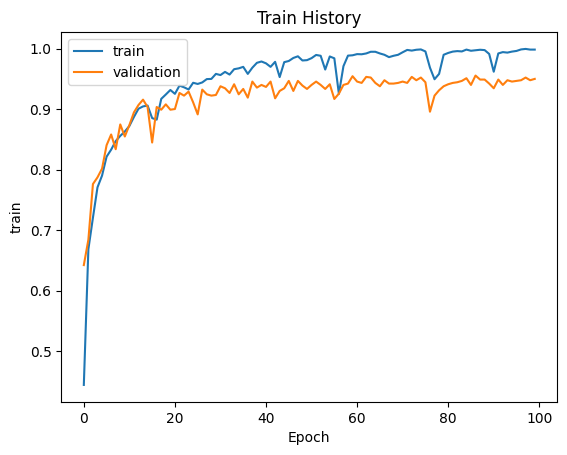

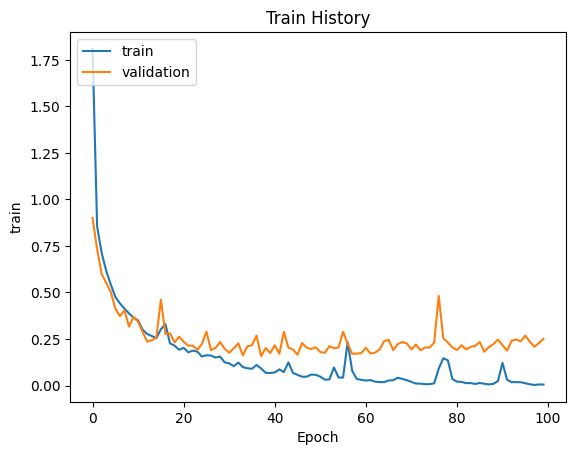

In [193]:
def show_train_history(train_history, train, validation):

    plt.plot(train_history.history[train])

    plt.plot(train_history.history[validation])

    plt.title('Train History')

    plt.ylabel('train')

    plt.xlabel('Epoch')

    plt.legend(['train', 'validation'], loc='upper left')

    plt.show()
    

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

## 使用未參與訓練的測試資料測試，模型準確率

In [194]:
scores = model.evaluate(X_test,y_test,verbose=0)

print('Accuracy = ', scores[1])

Accuracy =  0.9521276354789734


## 評估訓練結果

36/36 [==============================] - 0s 2ms/step


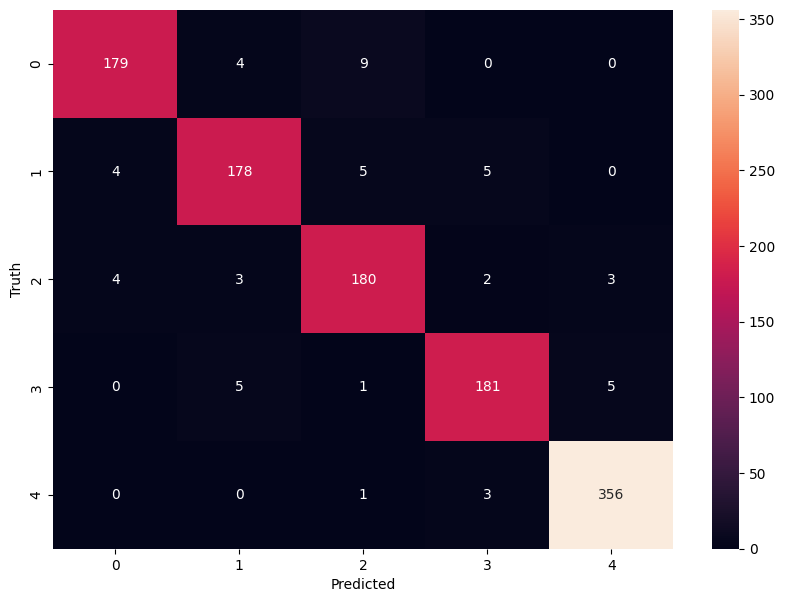

In [195]:
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()